<a href="https://colab.research.google.com/github/yyjshuju/gae/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# layers

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn.modules.module import Module
from torch.nn.parameter import Parameter

In [ ]:
class SparseMM(torch.autograd.Function):
    """
    Sparse x dense matrix multiplication with autograd support.

    Implementation by Soumith Chintala:
    https://discuss.pytorch.org/t/does-pytorch-support-autograd-on-sparse-matrix/6156/7
    """

    @staticmethod
    def forward(ctx, matrix1, matrix2):
        ctx.save_for_backward(matrix1, matrix2)
        return torch.mm(matrix1, matrix2)

    @staticmethod
    def backward(ctx, grad_output):
        matrix1, matrix2 = ctx.saved_tensors
        grad_matrix1 = grad_matrix2 = None

        if ctx.needs_input_grad[0]:
            grad_matrix1 = torch.mm(grad_output, matrix2.t())

        if ctx.needs_input_grad[1]:
            grad_matrix2 = torch.mm(matrix1.t(), grad_output)

        return grad_matrix1, grad_matrix2


"""
  Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
  """

class GraphConvolution(Module):
    def __init__(self, in_features, out_features, dropout=0., act=F.relu):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.sparse_mm = SparseMM.apply
        self.act = act
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)

    def forward(self, input, adj):
        input = F.dropout(input, self.dropout, self.training)
        # support = torch.mm(input, self.weight)
        # output = torch.spmm(adj, support)
        support = self.sparse_mm(input, self.weight)
        output = self.sparse_mm(adj, support)
        output = self.act(output)
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'




# **Model**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import math

In [ ]:
class GCNModelVAE(nn.Module):
    def __init__(self, input_feat_dim, hidden_dim,hidden_dim1, hidden_dim2, hidden_dim3,hidden_dim4, dropout):
        super(GCNModelVAE, self).__init__()
        self.gc1 = GraphConvolution(input_feat_dim, hidden_dim1, dropout, act=F.relu)
        self.gc2 = GraphConvolution(hidden_dim1, hidden_dim2, dropout, act=lambda x: x)
        self.gc3 = GraphConvolution(hidden_dim1, hidden_dim2, dropout, act=lambda x: x)

        self.dense = LinearNet(hidden_dim2, hidden_dim3, dropout, act=F.sigmoid)
        self.dense1 = LinearNet(hidden_dim3, 3, dropout, act=F.sigmoid)#cora 7/pumb 3/ci 6
        self.dc = InnerProductDecoder(dropout, act=lambda x: x)

    def encode(self, x, adj):
                hidden1 = self.gc1(x, adj)
                return self.gc2(hidden1, adj), self.gc3(hidden1, adj)
                # return self.dense1(hidden1, adj), self.dense2(hidden1, adj)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x, adj):
        mu, logvar = self.encode(x, adj)
        mu = self.dense(mu)
        logvar = self.dense(logvar)
        z = self.reparameterize(mu, logvar)
        return self.dc(z),self.dense1(z), mu, logvar

class GCNModelVAEen(nn.Module):
    def __init__(self, input_feat_dim, hidden_dim,hidden_dim1, hidden_dim2, hidden_dim3,hidden_dim4, dropout):
        super(GCNModelVAEen, self).__init__()
        self.gc1 = GraphConvolution(input_feat_dim, hidden_dim1, dropout, act=F.relu)
        self.gc2 = GraphConvolution(hidden_dim1, hidden_dim2, dropout, act=lambda x: x)
        self.gc3 = GraphConvolution(hidden_dim1, hidden_dim2, dropout, act=lambda x: x)
    def encode(self, x, adj):
        hidden1 = self.gc1(x, adj)
        return self.gc2(hidden1, adj), self.gc3(hidden1, adj)
                # return self.dense1(hidden1, adj), self.dense2(hidden1, adj)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x, adj):
        mu, logvar = self.encode(x, adj)
        z = self.reparameterize(mu, logvar)
        return mu, logvar

    """Decoder for using inner product for prediction."""
class LinearNet(nn.Module):
    def __init__(self, n_feature,out_features,dropout, act=F.relu):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, out_features)
        self.dropout = dropout
        self.act = act
    # forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y


class InnerProductDecoder(nn.Module):
    def __init__(self, dropout, act=torch.sigmoid):
        super(InnerProductDecoder, self).__init__()
        self.dropout = dropout
        self.act = act

    def forward(self, z):
        z = F.dropout(z, self.dropout, training=self.training)
        adj = self.act(torch.mm(z, z.t()))
        return adj

class Discriminator(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Discriminator, self).__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x
class VEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

# Utils

In [ ]:
import pickle as pkl
import pickle
import networkx as nx
import numpy as np
import scipy.sparse as sp
from scipy import sparse
import torch
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import matplotlib.pyplot as plt
import os
import os.path as osp
import itertools
from collections import namedtuple
Data = namedtuple('Data', ['x', 'y', 'adjacency',
                           'train_mask', 'val_mask', 'test_mask'])
def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

def tensor_from_numpy(x, device):
    return torch.from_numpy(x).to(device)

def load_data(dataset):
    names = ['x', 'tx', 'allx', 'y', 'ty', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("drive/MyDrive/data/ind.{}.{}".format(dataset, names[i]), 'rb') as rf:
            u = pkl._Unpickler(rf)
            u.encoding = 'latin1'
            cur_data = u.load()
            objects.append(cur_data)
    x, tx, allx, y, ty, ally, graph= tuple(objects)
    test_idx_reorder = parse_index_file(
        "data/ind.{}.test.index".format(dataset))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    train_index = np.arange(y.shape[0])
    val_index = np.arange(y.shape[0], y.shape[0] + 500)
    stx = tx.A
    sallx=allx.A
    x1 = np.concatenate((sallx, stx), axis=0)
    y1= np.concatenate((ally, ty), axis=0).argmax(axis=1)

    x1[test_idx_reorder] = x1[test_idx_range]
    y1[test_idx_reorder] = y1[test_idx_range]
    num_nodes = x1.shape[0]

    train_mask = np.zeros(num_nodes, dtype=np.bool)
    val_mask = np.zeros(num_nodes, dtype=np.bool)
    test_mask = np.zeros(num_nodes, dtype=np.bool)
    train_mask[train_index] = True
    val_mask[val_index] = True
    test_mask[test_idx_reorder] = True

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    features = torch.FloatTensor(np.array(features.todense()))
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))
    # return adj, features
    return x1, y1, train_mask, val_mask, test_mask, adj, features

def parse_index_file(filename):
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index


def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape


def mask_test_edges(adj):
    # Function to build test set with 10% positive links
    # NOTE: Splits are randomized and results might slightly deviate from reported numbers in the paper.
    # TODO: Clean up.

    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()
    # Check that diag is zero:
    assert np.diag(adj.todense()).sum() == 0

    adj_triu = sp.triu(adj)
    adj_tuple = sparse_to_tuple(adj_triu)
    edges = adj_tuple[0]
    edges_all = sparse_to_tuple(adj)[0]
    num_test = int(np.floor(edges.shape[0] / 10.))
    num_val = int(np.floor(edges.shape[0] / 20.))

    all_edge_idx = list(range(edges.shape[0]))
    np.random.shuffle(all_edge_idx)
    val_edge_idx = all_edge_idx[:num_val]
    test_edge_idx = all_edge_idx[num_val:(num_val + num_test)]
    test_edges = edges[test_edge_idx]
    val_edges = edges[val_edge_idx]
    train_edges = np.delete(edges, np.hstack([test_edge_idx, val_edge_idx]), axis=0)

    def ismember(a, b, tol=5):
        rows_close = np.all(np.round(a - b[:, None], tol) == 0, axis=-1)
        return np.any(rows_close)

    test_edges_false = []
    while len(test_edges_false) < len(test_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue
        if ismember([idx_i, idx_j], edges_all):
            continue
        if test_edges_false:
            if ismember([idx_j, idx_i], np.array(test_edges_false)):
                continue
            if ismember([idx_i, idx_j], np.array(test_edges_false)):
                continue
        test_edges_false.append([idx_i, idx_j])

    val_edges_false = []
    while len(val_edges_false) < len(val_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue
        if ismember([idx_i, idx_j], train_edges):
            continue
        if ismember([idx_j, idx_i], train_edges):
            continue
        if ismember([idx_i, idx_j], val_edges):
            continue
        if ismember([idx_j, idx_i], val_edges):
            continue
        if val_edges_false:
            if ismember([idx_j, idx_i], np.array(val_edges_false)):
                continue
            if ismember([idx_i, idx_j], np.array(val_edges_false)):
                continue
        val_edges_false.append([idx_i, idx_j])

    assert ~ismember(test_edges_false, edges_all)
    assert ~ismember(val_edges_false, edges_all)
    assert ~ismember(val_edges, train_edges)
    assert ~ismember(test_edges, train_edges)
    assert ~ismember(val_edges, test_edges)

    data = np.ones(train_edges.shape[0])

    # Re-build adj matrix
    adj_train = sp.csr_matrix((data, (train_edges[:, 0], train_edges[:, 1])), shape=adj.shape)
    adj_train = adj_train + adj_train.T

    # NOTE: these edge lists only contain single direction of edge!
    return adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false


def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    # return sparse_to_tuple(adj_normalized)
    return sparse_mx_to_torch_sparse_tensor(adj_normalized)


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def plot_results(results, test_freq, path='results.png'):
    # Init
    plt.close('all')
    fig = plt.figure(figsize=(8, 8))

    x_axis_train = range(len(results['train_elbo']))
    x_axis_test = range(0, len(x_axis_train), test_freq)
    # Elbo
    ax = fig.add_subplot(2, 2, 1)
    ax.plot(x_axis_train, results['train_elbo'])
    ax.set_ylabel('Loss (ELBO)')
    ax.set_title('Loss (ELBO)')
    ax.legend(['Train'], loc='upper right')

    # Accuracy
    ax = fig.add_subplot(2, 2, 2)
    ax.plot(x_axis_train, results['accuracy_train'])
    ax.plot(x_axis_test, results['accuracy_test'])
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy')
    ax.legend(['Train', 'Test'], loc='lower right')

    # ROC
    ax = fig.add_subplot(2, 2, 3)
    ax.plot(x_axis_train, results['roc_train'])
    ax.plot(x_axis_test, results['roc_test'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('ROC AUC')
    ax.set_title('ROC AUC')
    ax.legend(['Train', 'Test'], loc='lower right')

    # Precision
    ax = fig.add_subplot(2, 2, 4)
    ax.plot(x_axis_train, results['ap_train'])
    ax.plot(x_axis_test, results['ap_test'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Precision')
    ax.set_title('Precision')
    ax.legend(['Train', 'Test'], loc='lower right')

    # Save
    fig.tight_layout()
    fig.savefig(path)

def  get_roc_score(emb, adj_orig, edges_pos, edges_neg):
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)
    accuracy = accuracy_score((preds_all > 0.5).astype(float), labels_all)
    return roc_score, ap_score, accuracy


# Train

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.11.0+cu113
     |████████████████████████████████| 7.9 MB 2.8 MB/s 
     |████████████████████████████████| 3.5 MB 37 kB/s 


In [ ]:
from __future__ import division
from __future__ import print_function
import os.path as osp
import argparse
import time

import numpy as np
import scipy.sparse as sp
import torch.nn as nn
import torch
from torch import optim
from collections import defaultdict
# from model import GCNModelVAE,Discriminator
# from optimizer import loss_function
# from utils import load_data, mask_test_edges, preprocess_graph, get_roc_score, tensor_from_numpy
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models.autoencoder import ARGVA
from torch_geometric.utils import train_test_split_edges



parser = argparse.ArgumentParser()
parser.add_argument('--model', type=str, default='gcn_vae')
parser.add_argument('--seed', type=int, default=42)
parser.add_argument('--epochs', type=int, default=200)
parser.add_argument('--hidden', type=int, default=50)
parser.add_argument('--hidden1', type=int, default=64)
parser.add_argument('--hidden2', type=int, default=32)
parser.add_argument('--hidden3', type=int, default=16)
parser.add_argument('--hidden4', type=int, default=32)
parser.add_argument('--lr', type=float, default=0.001)#0.0261/0.043
parser.add_argument('--dropout', type=float, default=0.00)
parser.add_argument('--dataset-str', type=str, default='cora')
parser.add_argument('--test_freq', type=int, default='10')
# args = parser.parse_args()
parser.parse_known_args()[0]

# Cora数据集(引文网络)由机器学习论文组成
# PubMed数据集(引文网络)包括来自Pubmed数据库的19717篇关于糖尿病的科学出版物，分为三类
# CiteSeer数据集(引文网络)中，论文分为六类

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} dataset".format('pubmed'))
# adj, features = load_data(args.dataset_str)
x, y, train_mask, val_mask, test_mask, adj, features= load_data('pubmed')
n_nodes, feat_dim = features.shape
# dataset = load_data2().data
node_feature = x / x.sum(1, keepdims=True)  # 归一化数据，使得每一行和为1
tensor_x = tensor_from_numpy(node_feature, DEVICE)
tensor_y = tensor_from_numpy(y, DEVICE)
tensor_train_mask = tensor_from_numpy(train_mask, DEVICE)
tensor_val_mask = tensor_from_numpy(val_mask, DEVICE)
tensor_test_mask = tensor_from_numpy(test_mask, DEVICE)
num_nodes, input_dim = node_feature.shape
# normalize_adjacency = load_data2.normalization(dataset.adjacency)
# indices = torch.from_numpy(np.asarray([normalize_adjacency.row,
#                                        normalize_adjacency.col]).astype('int64')).long()
# values = torch.from_numpy(normalize_adjacency.data.astype(np.float32))
# tensor_adjacency = torch.sparse.FloatTensor(indices, values,
#                                             (num_nodes, num_nodes)).to(DEVICE)

# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
adj = adj_train


adj_norm = preprocess_graph(adj)
# adj_label = adj + sp.eye(adj.shape[0])
# adj_label = torch.FloatTensor(adj_label.toarray())
# pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
# norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
# model = GCNModelVAE(feat_dim, args.hidden, args.hidden1, args.hidden2, args.hidden3, args.hidden4, args.dropout)
# optimizer = optim.Adam(model.parameters(), lr=args.lr)
criterion = nn.CrossEntropyLoss().to(DEVICE)
    # optimizer = optim.AdaGrad(model.parameters(), lr=args.lr) RAdam
encoder = GCNModelVAEen(feat_dim, 50, 64, 32, 16, 32, 0.00)
model = GCNModelVAE(feat_dim, 50, 64, 32, 16, 32, 0.00)

Using pubmed dataset


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

Epoch: 0001 train_loss= 1.20318 train_acc= 0.33333 train_acc2= 0.41600 time= 1.80448
Epoch: 0002 train_loss= 1.09407 train_acc= 0.33333 train_acc2= 0.41600 time= 3.43146
Epoch: 0003 train_loss= 1.08675 train_acc= 0.33333 train_acc2= 0.41600 time= 5.04130
Epoch: 0004 train_loss= 1.07835 train_acc= 0.33333 train_acc2= 0.41600 time= 6.62564
Epoch: 0005 train_loss= 1.06861 train_acc= 0.35000 train_acc2= 0.43000 time= 8.21668
Epoch: 0006 train_loss= 1.05731 train_acc= 0.40000 train_acc2= 0.48400 time= 9.80702
Epoch: 0007 train_loss= 1.04420 train_acc= 0.51667 train_acc2= 0.62800 time= 11.39638
Epoch: 0008 train_loss= 1.02903 train_acc= 0.51667 train_acc2= 0.65000 time= 13.01228
Epoch: 0009 train_loss= 1.01159 train_acc= 0.51667 train_acc2= 0.62200 time= 14.58122
Epoch: 0010 train_loss= 0.99174 train_acc= 0.51667 train_acc2= 0.59400 time= 16.15031
Epoch: 0011 train_loss= 0.96938 train_acc= 0.53333 train_acc2= 0.58400 time= 17.73071
Epoch: 0012 train_loss= 0.94438 train_acc= 0.55000 train_acc

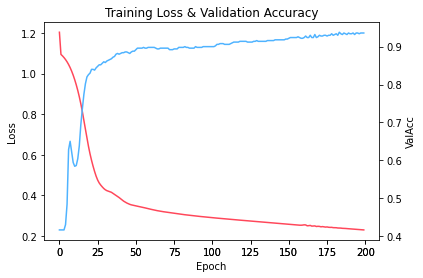

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


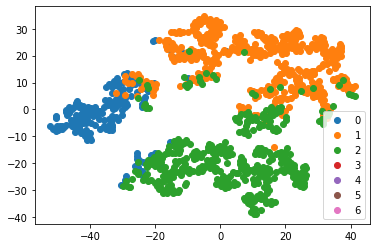

In [ ]:
results = defaultdict(list)
hidden_emb = None
discriminator = Discriminator(in_channels=32, hidden_channels=16, 
                              out_channels=1) # Comment
model2 = ARGVA(encoder, discriminator)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.005)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
def gae_for():
    loss_history = []
    val_acc_history = []
    t = time.time()
    model2.train()
    model.train
    for epoch in range(200):
        optimizer.zero_grad(set_to_none=True)
        encoder_optimizer.zero_grad(set_to_none=True)
        # mu,logve = encoder(features, adj_norm)
        z = model2.encode(features, adj_norm)
        for i in range(5):
            idx = range(num_nodes)
            discriminator.train()
            discriminator_optimizer.zero_grad()
            discriminator_loss = model2.discriminator_loss(z[idx])  # Comment
            discriminator_loss.backward(retain_graph=True)
            discriminator_optimizer.step()
        recovered, z, mu, logvar = model(features, adj_norm)
        loss = criterion(z, tensor_y)  # 计算损失值
        loss.backward()
        # recovered, z, mu, logvar = model(features, adj_norm)
        cur_loss = loss.item()
        results['train_elbo'].append(cur_loss)
        # if 0 == epoch % 2:
            # optimizer.step()
            # optimizer.zero_grad(set_to_none=True)
        encoder_optimizer.step()
        optimizer.step()
        train_acc, _, _ = test(tensor_train_mask)  # 计算当前模型训练集上的准确率
        val_acc, _, _ = test(tensor_val_mask)  # 计算当前模型在验证集上的准确率
        loss_history.append(loss.item())
        val_acc_history.append(val_acc.item())
        print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(cur_loss),
              "train_acc=", "{:.5f}".format(train_acc),
              "train_acc2=", "{:.5f}".format(val_acc),
              # "val_ap=", "{:.5f}".format(ap_curr),
              "time=", "{:.5f}".format(time.time() - t)
              )
    print("Optimization Finished!")
    return loss_history, val_acc_history

def test(mask):
    model.eval()
    with torch.no_grad():
        recovered,z, mu, logvar = model(features, adj_norm)
        test_mask_logits = z[mask]
        predict_y = test_mask_logits.max(1)[1]
        accuarcy = torch.eq(predict_y, tensor_y[mask]).float().mean()
    return accuarcy, test_mask_logits.cpu().numpy(),tensor_y[mask].cpu().numpy()

def plot_loss_with_acc(loss_history, val_acc_history):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(range(len(loss_history)), loss_history,
             c=np.array([255, 71, 90]) / 255.)
    plt.ylabel('Loss')

    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
    ax2.plot(range(len(val_acc_history)), val_acc_history,
             c=np.array([79, 179, 255]) / 255.)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.ylabel('ValAcc')

    plt.xlabel('Epoch')
    plt.title('Training Loss & Validation Accuracy')
    plt.show()


loss, val_acc = gae_for()
test_acc, test_logits, test_label = test(tensor_test_mask)
print("Test accuarcy: ", test_acc.item())

plot_loss_with_acc(loss, val_acc)

from sklearn.manifold import TSNE
tsne = TSNE()
out = tsne.fit_transform(test_logits)
fig = plt.figure()
for i in range(7):
    indices = test_label == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))
plt.legend(loc=0)
plt.savefig('tsne.png')
plt.show()